<a href="https://colab.research.google.com/github/weswest/MSDS422/blob/main/MSDS_422_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 Project Overview

This workbook performs basic introductory EDA on the Ames, Iowa Housing dataset available on Kaggle: [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

This is Assignment 1 for the Northwestern MSDS-422 Practical Machine Learning course.  Abbreviated instructions for this assignment:

You are to conduct EDA on the dataset as follows. 

1. Provide appropriate descriptive statistics and visualizations to help understand the marginal distribution of the dependent variable.
2. Investigate missing data and outliers.
3. Investigate at least three potential predictors of the dependent variable and provide appropriate graphs / statistics to demonstrate the relationships.
4. Engage in feature creation by splitting, merging, or otherwise generating a new predictor.
5. Using the dependent variable, perform both min-max and standard scaling in Python.



# 0 Setup


## 0.1 Setup - Load Libraries

In [3]:
import pandas as pd
import numpy as np
import math
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, skew
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

## 0.2 Setup - Operating Environment
This code allows the Colab notebook to access my Google Drive files.

In [4]:
from google.colab import drive
drive.mount('/content/drive')
import os
try:
  os.chdir("drive/My Drive/MSDS/422/Ames")
except:
  pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 0.3 Setup - Read in Data
Note: the Kaggle dataset already splits the housing data into "train" and "test" sets.  This assignment allows us to ignore the test set for now

In [5]:
df = pd.read_csv('Data/train.csv')

In [6]:
print(df.shape)
print(df.select_dtypes(include=np.number).shape)
print(df.select_dtypes(exclude=np.number).shape)

print('We have 1460 observations, 81 variables: 38 number and 43 categorical')

(1460, 81)
(1460, 38)
(1460, 43)
We have 1460 observations, 81 variables: 38 number and 43 categorical


# 1 Explore the Dependent Variable (Sale Price)


## 1.1 DV Description

The code below shows that there is right skew: the mean of \$181k is higher than the median of \$163k.  Also, this highlights the range of sale prices from \$35k to \$755k

In [7]:
# 1.1 The code below pulls out the standard mean, median, min/max distributions for our key variable

print(df['SalePrice'].describe())
print('Median Sale Price: ',statistics.median(df['SalePrice']))

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64
Median Sale Price:  163000.0


## 1.2 DV Box Plot

The box and whisker plot is useful for identifying the typical values, as well as the outliers.

The graph below shows that there are a number of sale price outliers on the upper end of the graph, which is not unexpected given the right skew.

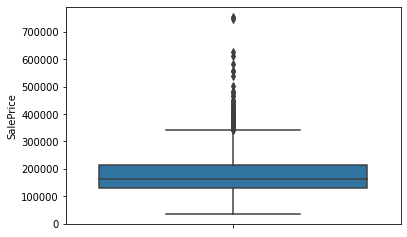

In [8]:
# 1.2 The code below reveals a large number of outliers, especially on the upper end
# This sort of result is indicative of a probable right skew

sns.boxplot( y=df["SalePrice"])
#plt.show()

## 1.3 DV Distribution

The next handful of code blocks get into what the DV distribution looks like.  The first code block directly shows the PD of Sale Price.  The second also overlays a normal distribution on top of the graph, to better understand how far away from normal the graph looks.

Spoiler: the Sale Price is not normal.

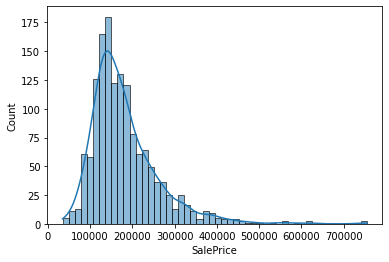

In [9]:
# 1.3 This graph below attempts to show the probability distribution of the DV
# As noted above, it looks likely there is right skew here

sns.histplot(x=df['SalePrice'], bins=50, kde=True)


 mu = 180921.20 and sigma = 79415.29



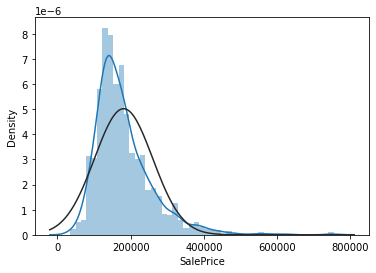

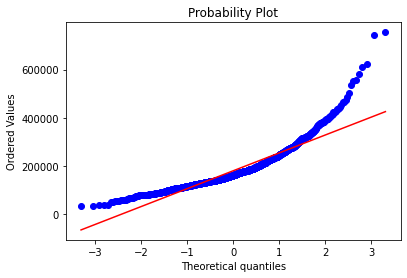

In [10]:
# Base function pulled from https://www.kaggle.com/anupjana/top-10-ames-house-pricing-stacked-regression
# and subsequently edited

# This code overlays the probability distribution of the key variable with a normal curve

def check_skewness(frame, col):
    sns.distplot(frame[col] , fit=norm);
    fig = plt.figure()
    res = stats.probplot(frame[col], plot=plt)
    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(df[col])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    
check_skewness(df, 'SalePrice')

## 1.4 DV Treatment - Log Transform
Note: this isn't specifically recommended within the assignment, but this is a useful approach to see if the transformation will result in a more normal distribution.  In this case, it very clearly does.

Note: log transformations convert the relationship between values from additive (values of 150 and 225 are 75 units apart) to multiplicative (ln(150) vs ln(225) is approximately a 50% increase).


 mu = 12.02 and sigma = 0.40



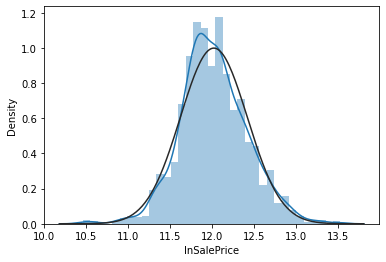

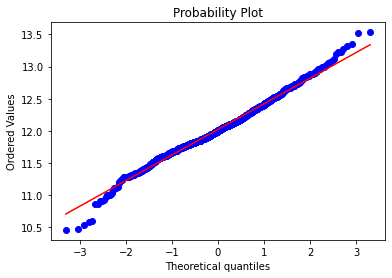

In [11]:
df['lnSalePrice'] = np.log(df['SalePrice'])
check_skewness(df, 'lnSalePrice')

# 2 Investigate Missing Data and Outliers

## 2.1 Investigate Missing Data



### 2.1.1 Naive Missing Data Research
Before digging into anything that we know about the data, let's take a look at missing values.

Hat tip to Dr Larry for the code used to graph missing data.

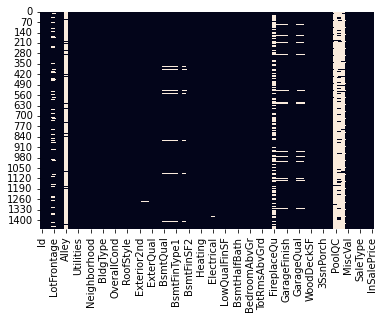

In [12]:
# Hat tip: https://github.com/dustoff06/MI/blob/main/MI%20Final%209%201%202021.ipynb

sns.heatmap(df.isnull(), cbar=False)

In [13]:
# Quick function that produces the 10 fields with the highest percentage of missing elements

def pct_missing(df):
  temp = df.isnull().sum() # This row generates a vector of Null counts
  temp = temp / len(df) # len(df) is the length of the dataset.  Dividing == %
  # This prints out the top 10 fields with missing rows
  return(temp.sort_values(ascending=False).head(10))

pct_missing(df)

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageQual      0.055479
GarageCond      0.055479
GarageFinish    0.055479
GarageType      0.055479
dtype: float64

**Conclusion:** There are a number of data fields with many missing values

### 2.1.2 Recharacterize "NA" as "No Feature" as appropriate.

Some very light research into the data dictionary indicates that many of the fields with missing values have "NA" encoded when in reality it's "No Feature".  It's important to retain these items, e.g., we don't want to delete the 99% of records without a pool.  It also doesn't make sense to backfill these values with, e.g., the average observed size of the pool.

The code below runs through all of the fields where the data dictionary clearly indicates that "NA" indicates "none of the feature"

LotFrontage    0.177397
GarageYrBlt    0.055479
MasVnrArea     0.005479
Electrical     0.000685
lnSalePrice    0.000000
Foundation     0.000000
RoofMatl       0.000000
Exterior1st    0.000000
Exterior2nd    0.000000
MasVnrType     0.000000
dtype: float64

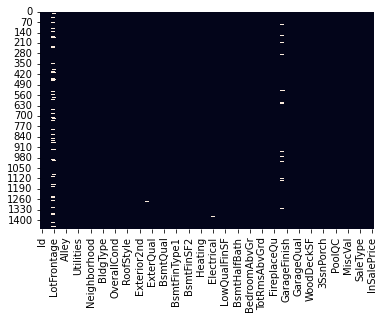

In [14]:
none_fields = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',
                 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'MasVnrType', 'PoolQC', 'Fence', 'MiscFeature']
df[none_fields] = df[none_fields].fillna('None')

sns.heatmap(df.isnull(), cbar=False)
pct_missing(df)

**Conclusion:** Filling in these known NAs removes nearly all of the missing values from the dataset.  The remaining columns require more consideration.

### 2.1.3 Determine what to do about LotFrontage
LotFrontage is the linear feet of the property attached to a street.  There's no a priori reason from the data dictionary why this would be null.

Others who have worked with the Ames dataset (see references above) fill in the lot frontage based on the neighborhood.  That seems like a smart approach, but it may not be the best.

Below I test whether the Building Type (e.g., Single Family or Townhouse) may be a better identifier.  The answer is clearly not.

The other thing I'm considering is whether we could identify an interim model to predict lot frontage from the lot area (e.g., if we assume Lot Area is a square then frontage = sqrt(Area).  First blush it looks like that wouldn't work great, plus that raises complications.  

**Conclusion:** To get through the day I'll follow the learnings of those who came before me and backfill to equal the neighborhood median.

In [15]:
df[df['LotFrontage'].isna()].head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,lnSalePrice
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,...,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,None,None,Shed,350,11,2009,WD,Normal,200000,12.206073
12,13,20,RL,NaN,12968,Pave,None,IR2,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,6,1962,1962,Hip,CompShg,HdBoard,Plywood,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,737,Unf,0,175,912,GasA,...,SBrkr,912,0,0,912,1,0,1,0,2,1,TA,4,Typ,0,None,Detchd,1962.0,Unf,1,352,TA,TA,Y,140,0,0,0,176,0,None,None,None,0,9,2008,WD,Normal,144000,11.877569
14,15,20,RL,NaN,10920,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,MetalSd,MetalSd,BrkFace,212.0,TA,TA,CBlock,TA,TA,No,BLQ,733,Unf,0,520,1253,GasA,...,SBrkr,1253,0,0,1253,1,0,1,1,2,1,TA,5,Typ,1,Fa,Attchd,1960.0,RFn,1,352,TA,TA,Y,0,213,176,0,0,0,None,GdWo,None,0,5,2008,WD,Normal,157000,11.964001
16,17,20,RL,NaN,11241,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,7,1970,1970,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,180.0,TA,TA,CBlock,TA,TA,No,ALQ,578,Unf,0,426,1004,GasA,...,SBrkr,1004,0,0,1004,1,0,1,0,2,1,TA,5,Typ,1,TA,Attchd,1970.0,Fin,2,480,TA,TA,Y,0,0,0,0,0,0,None,None,Shed,700,3,2010,WD,Normal,149000,11.911702
24,25,20,RL,NaN,8246,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,8,1968,2001,Gable,CompShg,Plywood,Plywood,None,0.0,TA,Gd,CBlock,TA,TA,Mn,Rec,188,ALQ,668,204,1060,GasA,...,SBrkr,1060,0,0,1060,1,0,1,0,3,1,Gd,6,Typ,1,TA,Attchd,1968.0,Unf,1,270,TA,TA,Y,406,90,0,0,0,0,None,MnPrv,None,0,5,2010,WD,Normal,154000,11.944708
31,32,20,RL,NaN,8544,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,6,1966,2006,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,1228,1228,GasA,...,SBrkr,1228,0,0,1228,0,0,1,1,3,1,Gd,6,Typ,0,None,Attchd,1966.0,Unf,1,271,TA,TA,Y,0,65,0,0,0,0,None,MnPrv,None,0,6,2008,WD,Normal,149350,11.914048
42,43,85,RL,NaN,9180,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,SFoyer,5,7,1983,1983,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,Gd,TA,Av,ALQ,747,LwQ,93,0,840,GasA,...,SBrkr,884,0,0,884,1,0,1,0,2,1,Gd,5,Typ,0,None,Attchd,1983.0,RFn,2,504,TA,Gd,Y,240,0,0,0,0,0,None,MnPrv,None,0,12,2007,WD,Normal,144000,11.877569
43,44,20,RL,NaN,9200,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,CollgCr,Norm,Norm,1Fam,1Story,5,6,1975,1980,Hip,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,Gd,TA,Av,LwQ,280,BLQ,491,167,938,GasA,...,SBrkr,938,0,0,938,1,0,1,0,3,1,TA,5,Typ,0,None,Detchd,1977.0,Unf,1,308,TA,TA,Y,145,0,0,0,0,0,None,MnPrv,None,0,7,2008,WD,Normal,130250,11.777211
50,51,60,RL,NaN,13869,Pave,None,IR2,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1997,1997,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,182,Unf,0,612,794,GasA,...,SBrkr,794,676,0,1470,0,1,2,0,3,1,TA,6,Typ,0,None,Attchd,1997.0,Fin,2,388,TA,TA,Y,0,75,0,0,0,0,None,None,None,0,7,2007,WD,Normal,177000,12.083905
64,65,60,RL,NaN,9375,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5

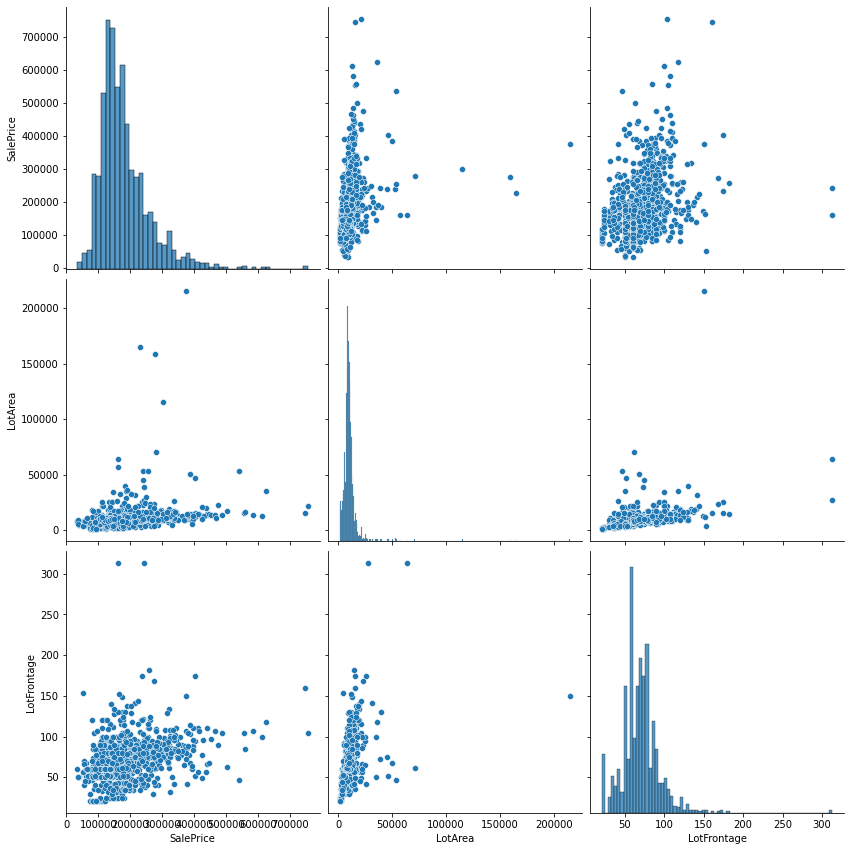

In [16]:
# The pairplot code produces all of the permutations of scatterplots for the input fields

pairs = ['SalePrice', 'LotArea', 'LotFrontage']
sns.pairplot(df[pairs], size = 4)
plt.show()
# Note we should probably come back to this for some of the outliers.

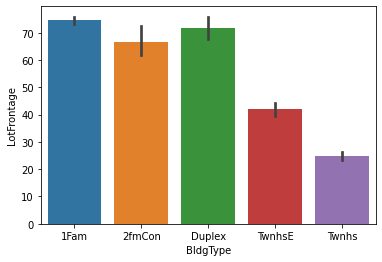

In [17]:

sns.barplot(x = df['BldgType'], y = df['LotFrontage'])


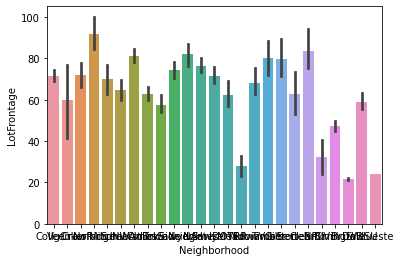

In [18]:
sns.barplot(x = df['Neighborhood'], y = df['LotFrontage'])

In [19]:
# Hat tip: https://www.kaggle.com/anupjana/top-10-ames-house-pricing-stacked-regression
df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
pct_missing(df)

GarageYrBlt    0.055479
MasVnrArea     0.005479
Electrical     0.000685
Foundation     0.000000
RoofStyle      0.000000
RoofMatl       0.000000
Exterior1st    0.000000
Exterior2nd    0.000000
MasVnrType     0.000000
ExterQual      0.000000
dtype: float64

### 2.1.4 Determine How to Handle GarageYrBlt

Ok, so these missing values are examples where there is no garage, so of course there's no year built.  What's the best way to fill these in?

I have to presume that at a later stage of feature selection the way we'd expect to use "GarageYrBlt" is to indicate whether the garage was built after the house (e.g., an addon).  If that's the case, the likely defining variable will be whether House Year = Garage Year or not.  So we will set Garage Year NAs to House Year.

In [20]:
df[df['GarageYrBlt'].isna()].head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,lnSalePrice
39,40,90,RL,65.0,6040,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,Duplex,1Story,4,5,1955,1955,Gable,CompShg,AsbShng,Plywood,None,0.0,TA,TA,PConc,None,None,None,None,0,None,0,0,0,GasA,...,FuseP,1152,0,0,1152,0,0,2,0,2,2,Fa,6,Typ,0,None,None,NaN,None,0,0,None,None,N,0,0,0,0,0,0,None,None,None,0,6,2008,WD,AdjLand,82000,11.314475
48,49,190,RM,33.0,4456,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,4,5,1920,2008,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,736,736,GasA,...,SBrkr,736,716,0,1452,0,0,2,0,2,3,TA,8,Typ,0,None,None,NaN,None,0,0,None,None,N,0,0,102,0,0,0,None,None,None,0,6,2009,New,Partial,113000,11.635143
78,79,90,RL,72.0,10778,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,4,5,1968,1968,Hip,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,1768,1768,GasA,...,SBrkr,1768,0,0,1768,0,0,2,0,4,2,TA,8,Typ,0,None,None,NaN,None,0,0,None,None,Y,0,0,0,0,0,0,None,None,None,0,4,2010,WD,Normal,136500,11.824080
88,89,50,C (all),105.0,8470,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,IDOTRR,Feedr,Feedr,1Fam,1.5Fin,3,2,1915,1982,Hip,CompShg,Plywood,Plywood,None,0.0,Fa,Fa,CBlock,TA,Fa,No,Unf,0,Unf,0,1013,1013,GasA,...,SBrkr,1013,0,513,1526,0,0,1,0,2,1,Fa,6,Typ,0,None,None,NaN,None,0,0,None,None,N,0,0,156,0,0,0,None,MnPrv,None,0,10,2009,ConLD,Abnorml,85000,11.350407
89,90,20,RL,60.0,8070,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,4,5,1994,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,588,Unf,0,402,990,GasA,...,SBrkr,990,0,0,990,1,0,1,0,3,1,TA,5,Typ,0,None,None,NaN,None,0,0,None,None,Y,0,0,0,0,0,0,None,None,None,0,8,2007,WD,Normal,123600,11.724806
99,100,20,RL,77.0,9320,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,5,1959,1959,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,569,Unf,0,381,950,GasA,...,SBrkr,1225,0,0,1225,1,0,1,1,3,1,TA,6,Typ,0,None,None,NaN,None,0,0,None,None,Y,352,0,0,0,0,0,None,None,Shed,400,1,2010,WD,Normal,128950,11.767180
108,109,50,RM,85.0,8500,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Artery,Norm,1Fam,1.5Fin,5,7,1919,2005,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,793,793,GasW,...,FuseF,997,520,0,1517,0,0,2,0,3,1,Fa,7,Typ,0,None,None,NaN,None,0,0,None,None,N,0,0,144,0,0,0,None,None,None,0,8,2007,WD,Normal,115000,11.652687
125,126,190,RM,60.0,6780,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,2fmCon,1.5Fin,6,8,1935,1982,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,Fa,CBlock,TA,TA,Av,GLQ,490,Unf,0,30,520,GasA,...,SBrkr,520,0,234,754,1,0,1,0,2,1,TA,5,Typ,0,None,None,NaN,None,0,0,None,None,N,53,0,0,0,0,0,None,None,None,0,6,2006,WD,Normal,84500,11.344507
127,128,45,RM,55.0,4388,Pave,None,IR1,Bnk,AllPub,Inside,Gtl,OldTown,Feedr,Norm,1Fam,1.5Unf,5,7,1930,1950,Gable,CompShg,WdShing,Wd Sdng,None,0.0,TA,Gd,BrkTil,TA,TA,No,LwQ,116,Unf,0,556,672,GasA,...,SBrkr,840,0,0,840,0,0,1,0,3,1,TA,5,Typ,1,TA,None,NaN,None,0,0,None,None,N,0,0,0,0,0,0,None,None,None,0,6,2007,WD,Normal,87000,11.373663
140,141,20,RL,70.0,10500,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,5,1971,1971,Gable,

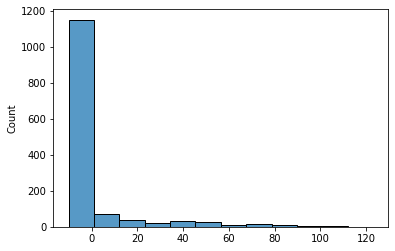

In [21]:
# This code confirms that in nearly all cases the Garage and House were built in the same year

test1 = df['GarageYrBlt'] - df['YearBuilt']
sns.histplot(test1)

In [22]:
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['YearBuilt'])
pct_missing(df)

MasVnrArea     0.005479
Electrical     0.000685
lnSalePrice    0.000000
Foundation     0.000000
RoofMatl       0.000000
Exterior1st    0.000000
Exterior2nd    0.000000
MasVnrType     0.000000
ExterQual      0.000000
ExterCond      0.000000
dtype: float64

### 3.1.5 Determine How To Handle MasVnrArea

These NAs are where the Masonry Veneer is "None", so these should just be zero.

In [23]:
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)
pct_missing(df)

Electrical     0.000685
lnSalePrice    0.000000
Foundation     0.000000
RoofMatl       0.000000
Exterior1st    0.000000
Exterior2nd    0.000000
MasVnrType     0.000000
MasVnrArea     0.000000
ExterQual      0.000000
ExterCond      0.000000
dtype: float64

### 3.1.6 Determine How To Handle Electrical

The most common Electrical value is 'SBrkr' by far.  So fill with that.

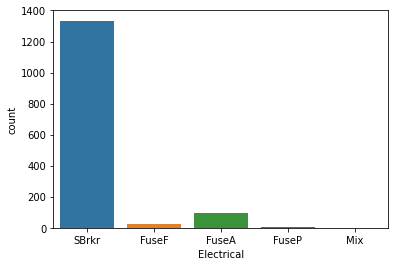

In [24]:
sns.countplot(x=df['Electrical'])

In [25]:
df['Electrical'] = df['Electrical'].fillna('SBrkr')
pct_missing(df)

lnSalePrice     0.0
YearRemodAdd    0.0
RoofMatl        0.0
Exterior1st     0.0
Exterior2nd     0.0
MasVnrType      0.0
MasVnrArea      0.0
ExterQual       0.0
ExterCond       0.0
Foundation      0.0
dtype: float64

## 2.2 Handling Outliers

If we take a naive look at sale price, then we see there are many observations that would meet the 1.5x IQR threshold.  That said, the distribution plot shared earlier in this notebook reveals a skew towards higher-priced homes that was materially resolved by log-transforming the sale price.

So for outlier treatment, we won't exclude all of the large sale prices.

Instead, we will follow an approach of identifying which fields have outliers (using the "extreme outlier" definition of 3*IQR above/below the first and third quartiles), and then graphing the field against sale price to make a judgment whether there are outliers.

### 2.2.1 Identify the fields with 3*IQR outliers

In [26]:
# Thanks for inspiration: https://stackoverflow.com/questions/39068214/how-to-count-outliers-for-all-columns-in-python/39068451#39068451

num_df = df.select_dtypes(include=np.number)
Q1 = num_df.quantile(0.25)
Q3 = num_df.quantile(0.75)
IQR = Q3 - Q1

temp = ((num_df < (Q1 - 3 * IQR)) | (num_df > (Q3 + 3 * IQR))).sum()
temp.sort_values(ascending=False)


EnclosedPorch    208
BsmtFinSF2       167
ScreenPorch      116
BsmtHalfBath      82
KitchenAbvGr      68
MiscVal           52
LotArea           34
MasVnrArea        28
LowQualFinSF      26
3SsnPorch         24
OpenPorchSF       18
LotFrontage       13
SalePrice         12
PoolArea           7
TotalBsmtSF        5
GrLivArea          4
WoodDeckSF         3
1stFlrSF           3
GarageArea         3
OverallCond        1
BsmtFinSF1         1
BedroomAbvGr       1
TotRmsAbvGrd       1
YearRemodAdd       0
YearBuilt          0
OverallQual        0
MSSubClass         0
lnSalePrice        0
FullBath           0
BsmtUnfSF          0
2ndFlrSF           0
BsmtFullBath       0
HalfBath           0
Fireplaces         0
GarageYrBlt        0
GarageCars         0
MoSold             0
YrSold             0
Id                 0
dtype: int64

## 2.2.2 Graph Fields with Extreme Outliers vs Sale Price

The block of code below implements expert judgment for how to handle extreme outliers in the dataset

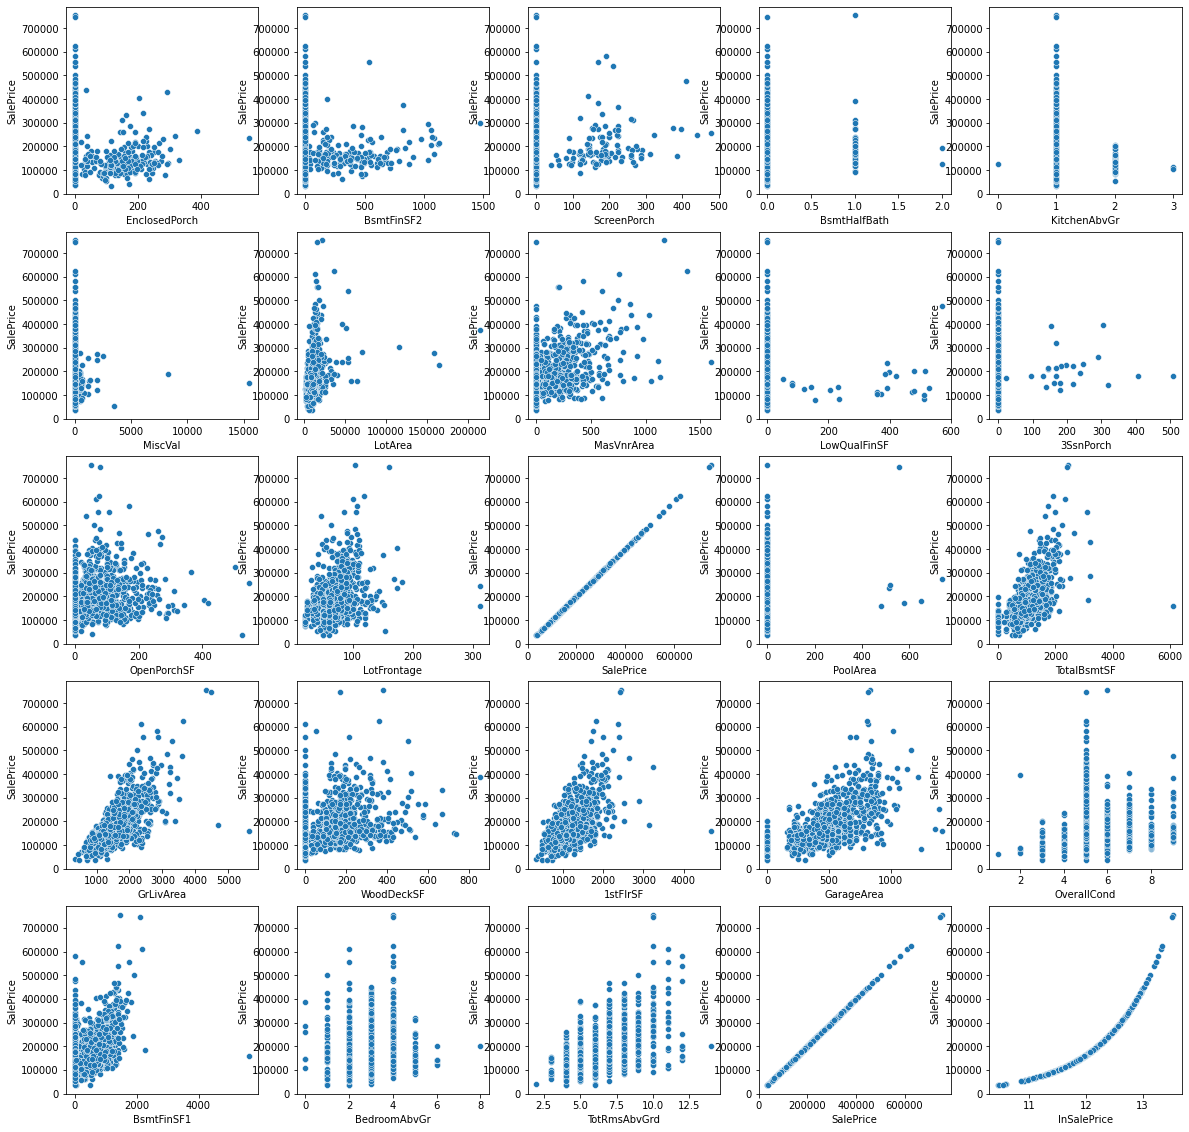

In [27]:

outliers = ['EnclosedPorch', 'BsmtFinSF2', 'ScreenPorch', 'BsmtHalfBath', 'KitchenAbvGr', 'MiscVal',
            'LotArea', 'MasVnrArea', 'LowQualFinSF', '3SsnPorch', 'OpenPorchSF', 'LotFrontage', 
            'SalePrice', 'PoolArea', 'TotalBsmtSF', 'GrLivArea', 'WoodDeckSF', '1stFlrSF', 
            'GarageArea', 'OverallCond', 'BsmtFinSF1', 'BedroomAbvGr', 'TotRmsAbvGrd',
            'SalePrice', 'lnSalePrice']

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20,20))
for i in range(5):
  for j in range(5):
    n = 5*i + j
    sns.scatterplot(x=outliers[n], y='SalePrice', data=df, ax=axs[i, j])

#Quick note for what's going on in the code above:
# the plt.subplots command allows you to create a grid of graphs, in this case 5x5
# the i, j loops iterate, so that we populate each cell into the "ax=axs[i,j]" cell
# Note that there were 23 outliers, including sale price
# I didn't want to fight with the code for errors for the last two cells, so I just populated them w/ Sale and lnSale


### 2.2.3 Exclude Outliers as Appropriate

Reviewing the graphs above, there are only a handful of cases where the data truly look like outliers:
* LotFrontage > 200
* TotalBsmtSF > 4000
* GRLivArea > 4000 AND Sale Price <300000
* 1stFlrSF > 4000

The code below drops these fields.

Note that these thresholds result in 3 observations being dropped, so there is some overlap where individual observations triggered multiple outlier criteria.

Look to the original paper [here](http://jse.amstat.org/v19n3/decock.pdf): the author suggests removing all datapoints with above-ground livable area >4,000: these exclusions get close to the original author's intent.

In [28]:
print(df.shape)
df = df.drop(df[df['LotFrontage'] > 200].index)
df = df.drop(df[df['TotalBsmtSF'] > 4000].index)
df = df.drop(df[(df['GrLivArea']>4000) & (df['SalePrice']<300000)].index)
df = df.drop(df[df['1stFlrSF'] > 4000].index)
print(df.shape)


(1460, 82)
(1457, 82)


## 3 IV ~ DV Correlation Research

Also as a way of doing some basic starts, we will look at which variables appear to be most highly correlated with sale price.

The homework assignment asks us to look at three fields.  I'll select two numeric and two categorical.

## 3.1 Numeric Fields

We'll use a correlation matrix to identify a few interesting fields for further research.

The code below pulls out the numeric fields with >0.5 correlation with SalePrice.  Note that "Sale Price" and "ln Sale Price" (created above) are triggreed.

The highest-correlated variables are:
* "OverallQual" (80% correlated)
* "GrLivArea" (73% correlated)


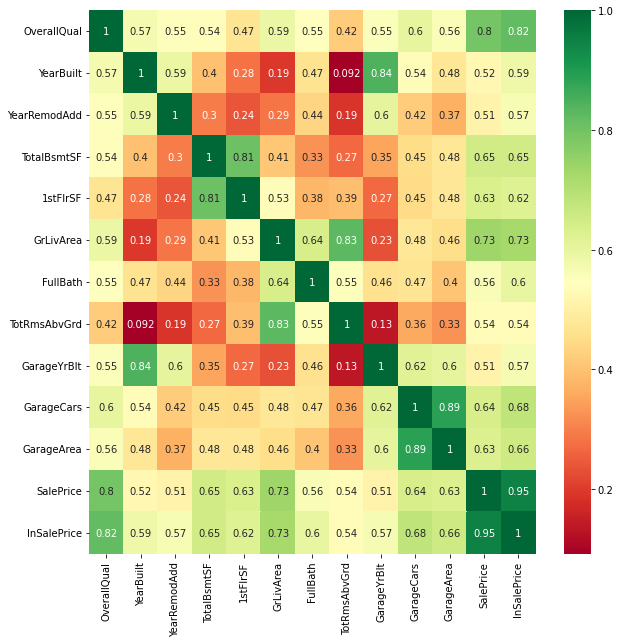

In [29]:
# Thanks to https://www.kaggle.com/anupjana/top-10-ames-house-pricing-stacked-regression

corrmat = df.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5] # the 0.5 is the cutoff for how related the variable should be
plt.figure(figsize=(10,10))
g = sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# 3.1.1 OverallQual

OverallQual is actually a categorical variable.  It is represented as a number, 1-10, with 1 = "Very Poor" and 10 = "Very Excellent."

The graphs below show that there is definitely an upward trend in sales price for higher quality.  Looking at the ln Sales, there isn't a lot of room for binning these, other than at the low end.

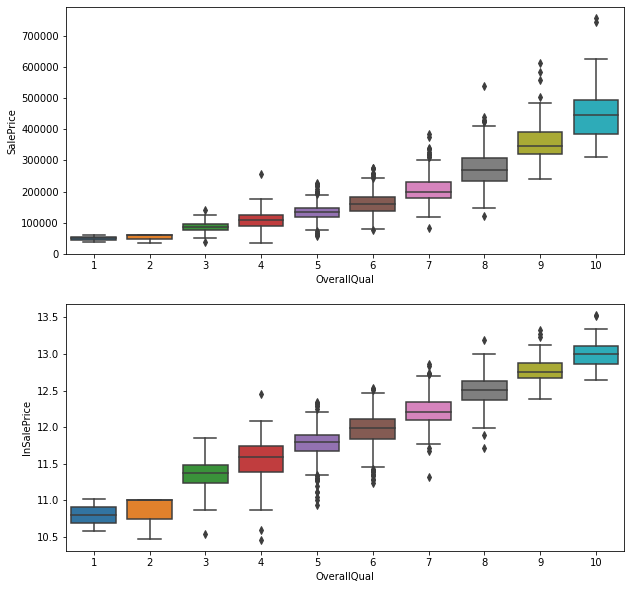

In [30]:
def boxresearch(col):
  fig, axs = plt.subplots(nrows=2, figsize=(10,10))

  sns.boxplot(x=df[col], y = df['SalePrice'], ax = axs[0])
  sns.boxplot(x=df[col], y = df['lnSalePrice'], ax = axs[1])

boxresearch('OverallQual')


### 3.1.2 GrLivArea

GrLivArea is the total livable square footage aboveground.  In theory, bigger = better.

To bring in some of that quality research, I color-code the scatterplot based on the quality score.  Note that some of the quality values get relatively thin, so I perform some basic binning here, with 1-3 as red, 4-6 as yellow, etc.

The striking conclusion here is that the yellows, greens, and some purples, all overlap in the livable area range of ~1300 to ~2500: in this range it seems like sale price is more strongly dictated by quality rather than by size.

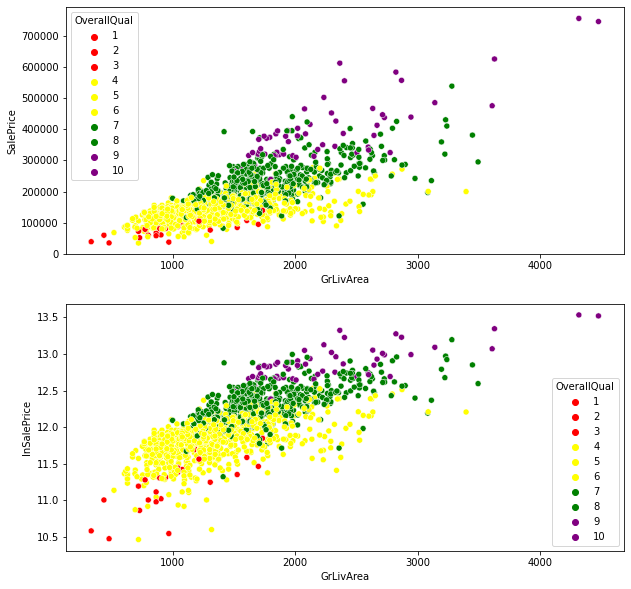

In [31]:
fig, axs = plt.subplots(nrows=2, figsize=(10,10))

colors = ['red', 'red', 'red', 'yellow', 'yellow', 'yellow', 'green', 'green', 'purple', 'purple']

sns.scatterplot(x=df['GrLivArea'], y = df['SalePrice'], hue = df['OverallQual'], palette = colors, ax = axs[0])
sns.scatterplot(x=df['GrLivArea'], y = df['lnSalePrice'], hue = df['OverallQual'], palette = colors, ax = axs[1])

## 3.2 Categorical Fields

For this stage we will grab a few categorical variables and try to identify whether there's a relationship.

Two immediately come to mind:
* Neighborhood.  Different areas probably have notably different sales expectations
* Month and/or Year Sold.  Two things going on here: first, there is well-known seasonality in home sales in the summer vs winter so we would expect to see some implication in sales price.  Second, the financial crisis happened in 2009 so we'd expect to see some drop in sales pre vs post.

### 3.2.1 Neighborhood Category

Yup.  Clearly a difference in sales price here.

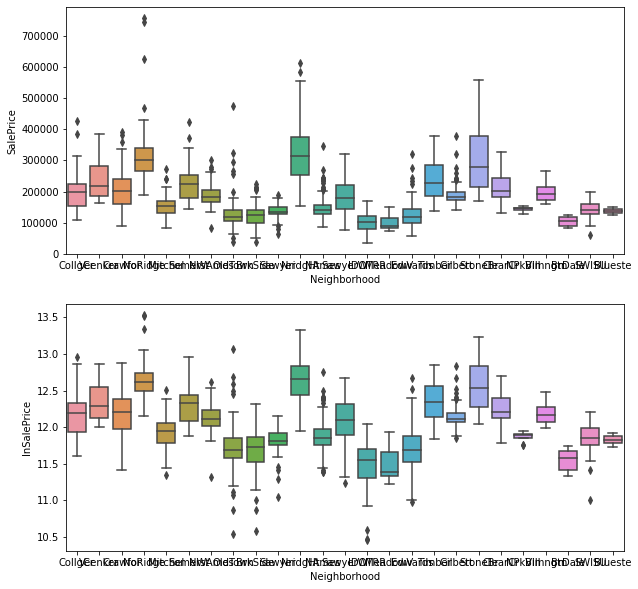

In [32]:
boxresearch('Neighborhood')

### 3.2.2 Date Sold

I was really surprised that there's relatively little impact on sale price in 2006-2007 vs 2008, 2009, 2010.  Maybe Ames, Iowa is too small to have been materially affected by the downturn.

I created a Year-Month variable (Feature Selection!), and there's some strong discontinuity there.  It may be worth using Year-Month as a predictor rather than Year or Month on its own.

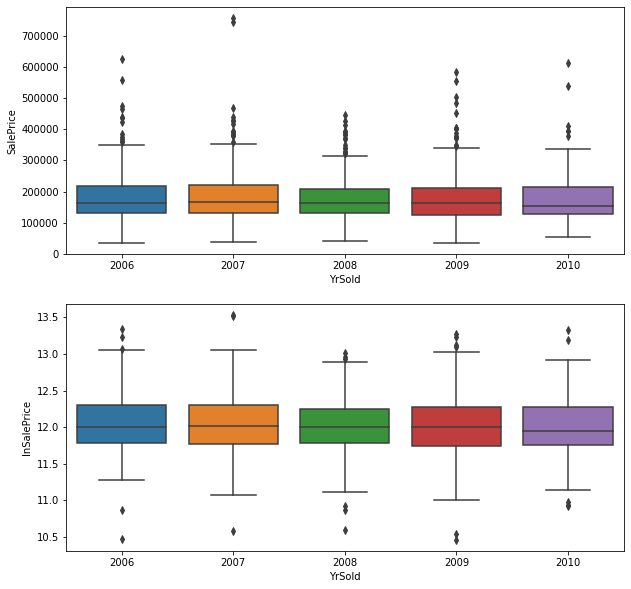

In [33]:
boxresearch('YrSold')

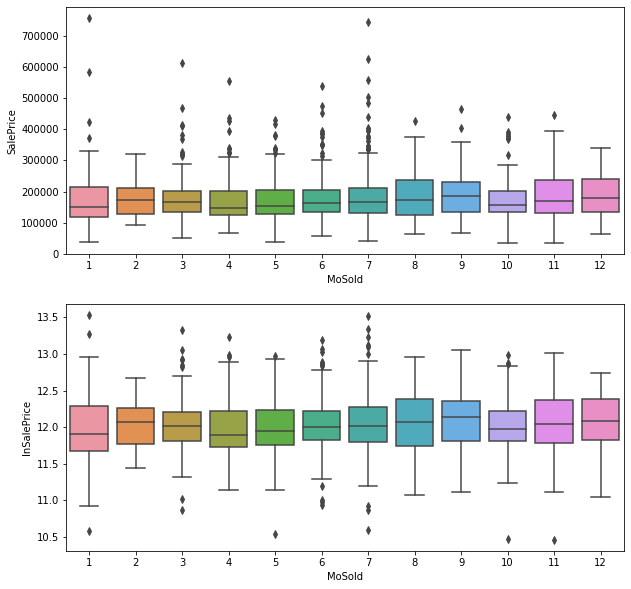

In [34]:
boxresearch('MoSold')

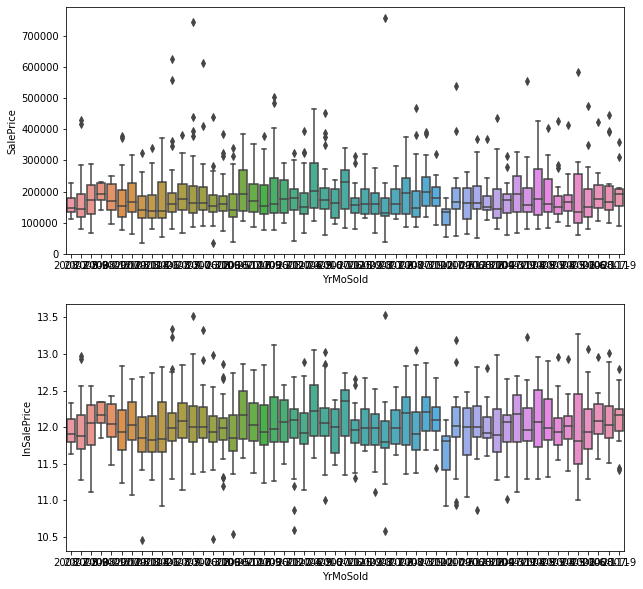

In [35]:
df['YrMoSold'] = df['YrSold'].astype('str') + '-' + df['MoSold'].astype('str')

boxresearch('YrMoSold')


# 4 Feature Generation - Total Bathrooms

In this stage we will create a new feature that could be used for modeling home sale price.

There are many options to choose from, but for simplicity we are going to create a "total bathrooms" metric which sums up the count of full and half baths above and below-ground.

Note that "half-baths" mean that there's no shower.  We could create some sort or weighting permutation on this, e.g., that a full bath counts as "1" and a half-bath counts as "0.5", but I'm going to skip that.

Note an area for further research would be to take the delta between number of bedrooms and number of full baths: it seems like one of the drivers of attractive home price would be if each bedroom has its own bath.  An area for future research.

# 4.1 Understanding Relationship of Input Features with Sale Price

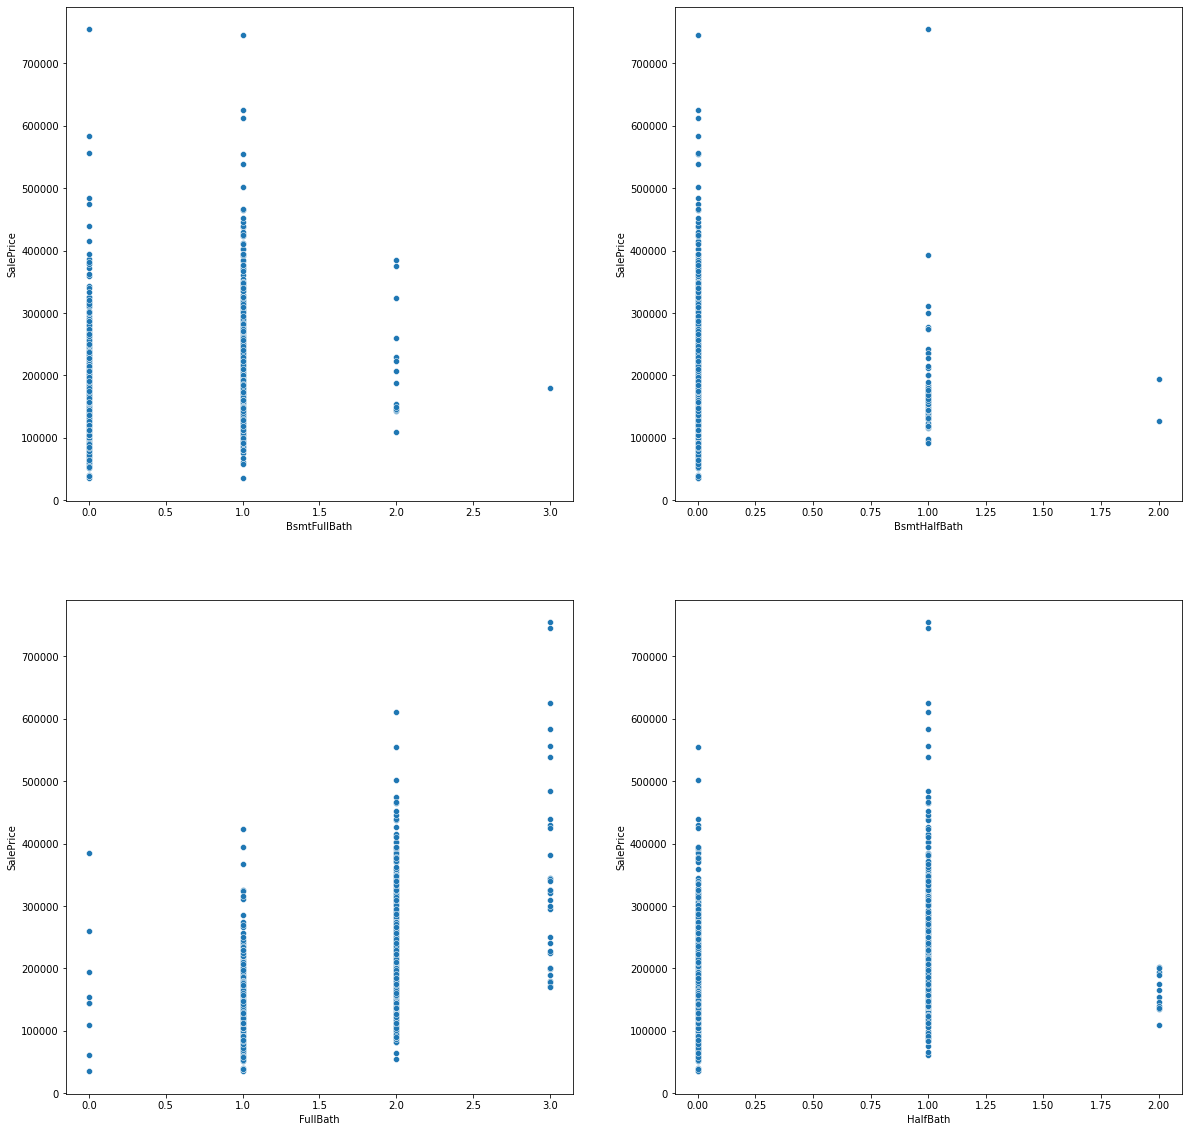

In [36]:
outliers = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath']

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
for i in range(2):
  for j in range(2):
    n = 2*i + j
    sns.scatterplot(x=outliers[n], y='SalePrice', data=df, ax=axs[i, j])

# 4.2 Create the Metric

Creates the "total baths" metric and then also compares it with sale price.  The upward trajectory from 1-4 makes sense, but the shape of 5 and 6 bathrooms warrants further research.

Digging in, there are only six observations with 5 bathrooms and only three observations with 6 bathrooms.  This upper-end has an "n" that's probably too small to rely upon.

In application, it will probably make more sense to create categorical variables where "4+ bathrooms" is the upper range.

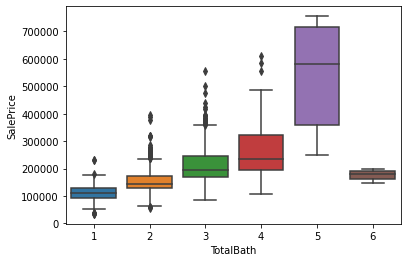

In [37]:
df['TotalBath'] = df['BsmtFullBath'] + df['BsmtHalfBath'] + df['FullBath'] + df['HalfBath']

#sns.scatterplot(x=df['TotalBath'], y = df['SalePrice'])
sns.boxplot(x=df['TotalBath'], y = df['SalePrice'])

In [38]:
df[df['TotalBath'] > 4].groupby(['TotalBath', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath']).size()



TotalBath  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath
5          0             1             3         1           2
           1             0             3         1           4
6          1             1             2         2           1
           2             0             2         2           1
           3             0             3         0           1
dtype: int64

# 5 Scaling the DV

The focus of this section appears to be exclusively on scaling the dependent variable, not the independent variables.

Note that there was already some work done at the top of the workbook to demonstrate that:
1. Sale price is skewed.  The average is much higher than the median
2. Log-transforming sale price does a powerful job of making the DV closer to a normalized distribution.

Further, rather than getting into the complexity of implementing a sklearn pipeline, I'm going to code up a standard scaler and a min/max scaler by hand.

Note that I used the same function to demonstrate skew that was defined earlier.  By definition, running these scaling approaches on the original SalePrice won't change the distribution: it will only change the scale.

## 5.1 Min-Max Scaling

Min-Max Scaling is where you reclassify a variable between 1 and 0.

The Min-Max scale is:

numerator: x - min(x)
denomenator: max(x) - min(x)

count    1457.000000
mean        0.202737
std         0.110410
min         0.000000
25%         0.131926
50%         0.177892
75%         0.248715
max         1.000000
Name: mmSalePrice, dtype: float64

 mu = 0.20 and sigma = 0.11



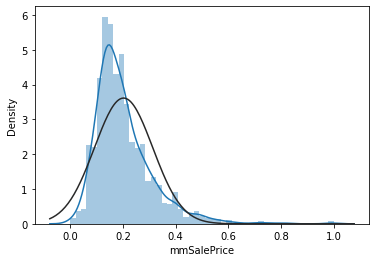

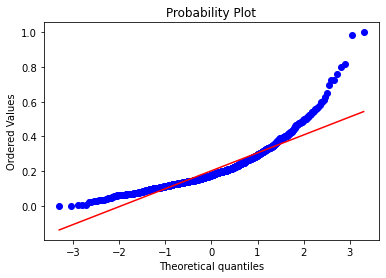

In [39]:
def minmax(col):
  num = df[col] - df[col].min()
  den = df[col].max() - df[col].min()
  return (num / den)

df['mmSalePrice'] = minmax('SalePrice')
print(df['mmSalePrice'].describe())
check_skewness(df, 'mmSalePrice')

## 5.2 Standard Scaler
The standard scaler approach reclassifies a variable so that the mean is zero and the standard deviation is 1.



count    1.457000e+03
mean    -1.652381e-16
std      1.000000e+00
min     -1.836221e+00
25%     -6.413460e-01
50%     -2.250265e-01
75%      4.164327e-01
max      7.220931e+00
Name: ssSalePrice, dtype: float64

 mu = -0.00 and sigma = 1.00



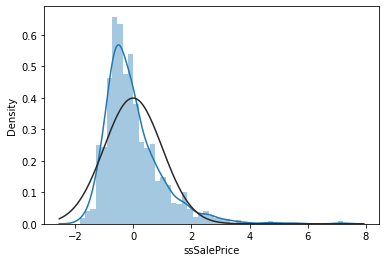

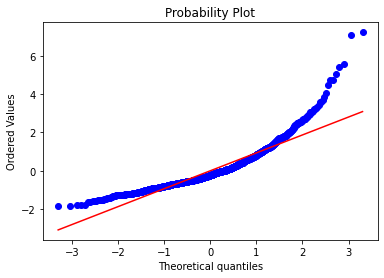

In [40]:
def normalize(col):
  num = df[col] - df[col].mean()
  den = df[col].std()
  return (num / den)

df['ssSalePrice'] = normalize('SalePrice')
print(df['ssSalePrice'].describe())
check_skewness(df, 'ssSalePrice')

# Locker Room / Notes

## Sources and Specific Notes
### https://www.kaggle.com/anupjana/top-17-ames-house-pricing-ensemble-regression/report
* EDA:
  * Distribution of sale price by neighborhood
  * Sale price by MSSubClass
* Feature creation ideas:
  * Create "Remodeled" as a dummy variable
  * Create "House Age" variable, diffing date sold and date built
  * Create "Is New House" if date sold is the same as date built
  * Do something with bathrooms: full and half baths summed
  * Aggregate total square footage summing basement and aboveground square footage

### https://www.kaggle.com/anupjana/top-10-ames-house-pricing-stacked-regression
(Note: this example scored in the top 10% of Kaggle scores)
 

## Miscellaneous code sources
* https://pythonbasics.org/seaborn-boxplot/
  * Used to pull the code for Seaborn boxplots
